<a href="https://colab.research.google.com/github/HungryCatsStudio/ml-models/blob/tensorflow-quantized/site/en/tutorials/quickstart/beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this script, we train two perceptrons for MNIST handwritten digit recognitions as TF Lite models

Main source: https://www.tensorflow.org/lite/performance/post_training_integer_quant

In [1]:
import tensorflow as tf
import numpy as np
import os

print("TensorFlow version:", tf.__version__)

HOME_DIR = os.getcwd()
MODEL_DIR = os.path.join(HOME_DIR, "models")

TensorFlow version: 2.15.0


In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10),
])

In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [5]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [6]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 359us/step - loss: 0.4672 - accuracy: 0.8783
Epoch 2/5
1875/1875 [==============================] - 1s 333us/step - loss: 0.3039 - accuracy: 0.9149
Epoch 3/5
1875/1875 [==============================] - 1s 342us/step - loss: 0.2835 - accuracy: 0.9204
Epoch 4/5
1875/1875 [==============================] - 1s 331us/step - loss: 0.2730 - accuracy: 0.9238
Epoch 5/5
1875/1875 [==============================] - 1s 329us/step - loss: 0.2663 - accuracy: 0.9260


In [7]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpwkk6gbhp/assets


INFO:tensorflow:Assets written to: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpwkk6gbhp/assets


INFO:tensorflow:Assets written to: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmp48xwajxr/assets


2024-01-23 10:42:38.196265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-23 10:42:38.196282: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-23 10:42:38.196708: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpwkk6gbhp
2024-01-23 10:42:38.197032: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-23 10:42:38.197036: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/1v/cqcqrbfj72l886q86rzfrmyc0000gn/T/tmpwkk6gbhp
2024-01-23 10:42:38.197662: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-23 10:42:38.198031: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-23 10:42:38.213464: I tensorflow/cc/saved_model/loader.

In [8]:
import pathlib

tflite_models_dir = pathlib.Path(MODEL_DIR)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"signed_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

9440

In [9]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices, argmax=True):

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    if argmax:
        predictions = np.zeros((len(test_image_indices),), dtype=int)
    else:
        predictions = np.zeros((len(test_image_indices), 10), dtype=float)

    for i, test_image_index in enumerate(test_image_indices):
        test_image = x_test[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax() if argmax else output

    return predictions

import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(x_test[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(y_test[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


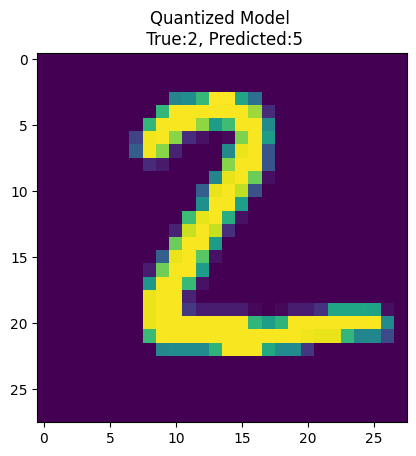

In [10]:
# test_model(tflite_model_file, test_image_index, model_type="Float")
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [11]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    test_image_indices = range(x_test.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(y_test== predictions) * 100) / len(x_test)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
        model_type, accuracy, len(x_test)))

In [12]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 8.9200% (Number of test samples=10000)


In [13]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.2643 - accuracy: 0.9255 - 189ms/epoch - 605us/step


[0.2642589211463928, 0.9254999756813049]

In [14]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [15]:
probability_model(x_test[0:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.8542639e-06, 6.8310697e-11, 1.0614485e-05, 5.1706112e-03,
        5.0636271e-07, 1.8298728e-05, 3.3281258e-10, 9.9431229e-01,
        1.6194066e-05, 4.6759512e-04]], dtype=float32)>

In [16]:
CHOSEN_EXAMPLE = 42

In [17]:
run_tflite_model(tflite_model_quant_file, [CHOSEN_EXAMPLE], argmax=False)

array([[-128., -128.,  -66.,  -87., -128.,  -61., -128., -128., -128.,
        -128.]])